In [ ]:
using Pkg #activate the Julia project in the main git repository
Pkg.activate("..")
using Plots, PhasorNetworks, Random #import the libraries (this cell takes ~30 s. to execute)

# A Brief Introduction

Decades of development in digital computing have provided us with numerous design and programming paradigms. While analog computing offers the ability to utilize the intrinsic dynamics of physical devices, no clear "winner" yet exists which can overcome challenges such as providing a flexible and comprehensible programming model for software. It has been proposed that hyperdimensional (HD) computing is one approach which can address these challenges by both providing a programming paradigm to users - in this tutorial, we'll introduce these concepts and show how this software package provides flexible and powerful simulation tools for HD computing on analog devices.

Let's start by defining the domain which we'll be using to express values in this computing model: phases.

# Phases

Waves are a highly common physical phenomena - from the the quantum wave equation, to macroscale phenomena such as sound, and gravitational waves which are light-years long. They also exist in the brain, as propagating "waves" of neural activity give rise to the hierarchy of frequencies observed in EEG and other measurement techniques. 

So, what values can be easily communicated with waves? Let's look at a simple sinusoidal wave:

In [1]:
function wave(A, t, k, ω, ϕ, x)
    return A * sin(k * x - ω * t + ϕ)
end

wave (generic function with 1 method)

In [3]:
A = 1.0
k = π / 2
xs = 0.0:0.01:5.0
ω = π
t = 0.0
ϕ = 0.0

0.0

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/wave_animation.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/wave_animation.gif")
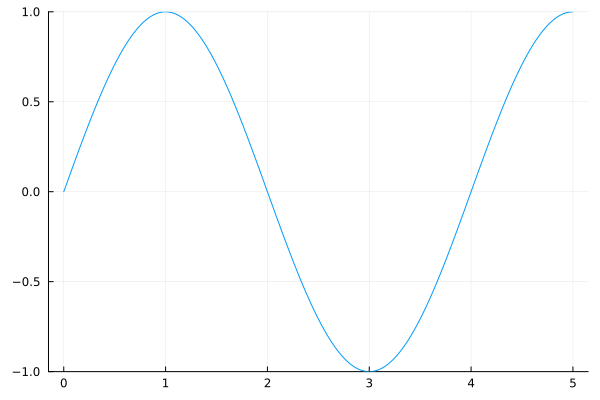

In [4]:
anim = @animate for t in 0:0.025:2
    plot(xs, wave.(A, t, k, ω, ϕ, xs), ylim=(-A, A), legend=false)
end
gif(anim, "wave_animation.gif", fps=20)

We can see that there are several different variables which we can play with: amplitude, wavelength, frequency, and phase. Whichever one we choose to modulate will produce impacts on the necessary hardware and methods for transmission. Anyone who has listened to AM radio - which modulates information into amplitude - can tell you it only gives good quality if you're close to the transmitter. Otherwise, frequency modulation (FM) gives a much cleaner signal, as the Earth's atmosphere (and distance) will attenuate a wave's amplitude, but is less likely to shift its frequency. However, frequency modulation comes with its own challenges - we have to make an oscillator (whatever generates the wave) which can oscillate quicker or slower on-demand. This may not be easy to control precisely, particularly if you have many oscillators - thousands or more.

The goal of this tutorial is to explore the advantages and capabilities of encoding information via phase. By looking between two waves and distinguishing when one peaks versus the other, we can easily measure their relative phases - it's essentially just a time delay from one wave to the other:

[ Info: Saved animation to /Users/wilkie/code/PhasorNetworks.jl/tutorial/wave_animation_phase.gif


Plots.AnimatedGif("/Users/wilkie/code/PhasorNetworks.jl/tutorial/wave_animation_phase.gif")
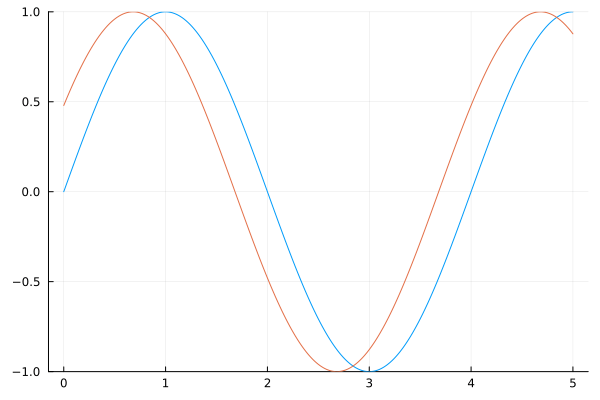

In [5]:
anim = @animate for t in 0:0.025:2
    plot(xs, wave.(A, t, k, ω, ϕ, xs), ylim=(-A, A), legend=false)
    plot!(xs, wave.(A, t, k, ω, ϕ + 0.5, xs), ylim=(-A, A), legend=false)
end
gif(anim, "wave_animation_phase.gif", fps=20)

By delaying a wave with an offset 0 seconds up to the wave's period, we can encode angular phase values from 0 to 2 $\pi$. Rather than imaging these values as real numbers on a line, we can imagine them as angular values on the unit circle:

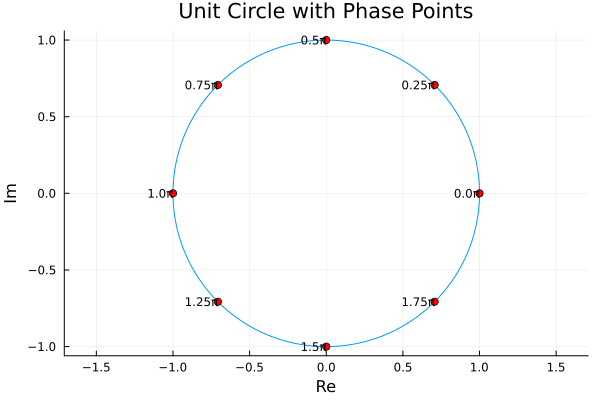

In [6]:
angles = 0:1/4:7/4         # 12 points around the circle
x = cos.(π .* angles)
y = sin.(π .* angles)

plt = plot(cos, sin, 0, 2π, aspect_ratio=1, legend=false, line=:solid, xlabel="Re", ylabel="Im", title="Unit Circle with Phase Points")
scatter!(x, y, color=:red, label="Phases")
for (xi, yi, θ) in zip(x, y, angles)
    annotate!(xi, yi, text("$(round(θ, digits=2))π", :right, 8))
end
plt

This dual but idential representation - a time-varying wave and a static phase - yields a unique method of computing which can be carried out either via standard maniupulation of floating-point values in a digital computer, or via superimposing and delaying waves in an analog computer. In this tutorial, we'll explore how this is possible and what we can do with it. 

But first, we'll make a brief introduction into the operations we'll be using to build applications, which are based on the approach of hyper-dimensional computing (HDC). Then, we will explore how these operations can be implemented using oscillator-based computing.

# Hyperdimensional Computing & Symbols

At a high level, HDCs aim to create computers which compute with concepts. Such a computer stores and manipulates 'symbols,' atomic pieces of information which can represent abstract features like 'cat,' 'eat,' and 'food.' How then should we physically represnt each of these concepts, and manipulate them together to represent a new concept such as "the cat eats the food?" Vector-symbolic architectures provide paths for accomplishing these calculations effectively. 

HDC approaches provide methods for defining and manipulating symbols. The common feature all HDC strategies is that each symbol is stored as a long series of values, or 'vector.' Conveniently for us, the FHRR HDC system uses a list of angles (-π to π in radians). This makes it compatible with representing these angles either via waves or floating-points!

For the assumptions behind HDC to be valid, a vector-symbol must have at least hundreds of elements (be "hyper"-dimensional), and HDC operations improve by scaling up to thousands of elements or more. 

To create a vector-symbol, you can select a series of random values on the domain defined by the HDC - in this case, not just one phase value, but hundreds. 

In [8]:
prng_key = Xoshiro("ICONS2025") # set a key for the PRNG

Xoshiro(0xf733fe83a71097a4, 0x695f7df03a3262f9, 0x115501062720e973, 0x7c145d15077fae82, 0xee8a09064dca155c)

In [ ]:
n_phases = 1024
n_symbols = 1;

1

In [10]:
symbol_1 = random_symbols((n_phases, n_symbols), prng_key)

1024×1 Matrix{Float32}:
 -0.3307488
 -0.47808385
  0.29505265
  0.32229865
  0.9167849
  0.049515367
  0.31454456
 -0.2640822
 -0.51329947
 -0.12103641
 -0.13066745
 -0.7273332
  0.8582511
  ⋮
  0.0791018
  0.42047608
 -0.023595452
 -0.4704739
  0.096874
 -0.36283243
 -0.3497578
 -0.74624825
  0.18155682
  0.041032314
 -0.81276524
 -0.6522589

As you can see, we've now created our first vector-symbol. It has 1000 values between -1 and 1, which can be multiplied by π to produce an angle in radians, or 180 to produce an angle in degrees. We can represent this as a "color barcode," where each stripe represents the position of an angle around a unit circle. Here, we plot only the first 100 angles for clarity. 

In [11]:
function plot_symbol(symbol::AbstractMatrix)
    fig = heatmap(symbol[1:100,1:1]', color=:hsv, clim=(-1, 1), aspect_ratio=6)
    xlabel!("Index")
end

plot_symbol (generic function with 1 method)

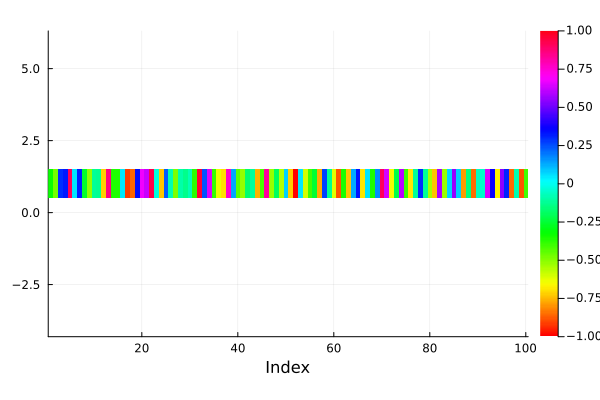

In [12]:
plot_symbol(symbol_1)

# Similarity

So what makes a vector-symbol useful? It can be compared with other symbols by a pre-defined metric, referred to as *similarity.* Symbols which are identical have a similarity of 1, and symbols which are unrelated have a similarity of (approximately) 0.

One of the astonishing properties of high-dimensional spaces which HDC leverages is the phenomenon that with certain metrics and vectors, the similarity of random vectors tends towards 0 as the vectors become longer. To demonstrate this, we'll first define the similarity metric for the FHRR HDC and then explore it as dimensionality shifts.

For the FHRR HDC, the similarity between two symbols is just the average of the cosine of difference in angles between the two vectors:

```
from src/vsa.jl:

function similarity(x::AbstractArray, y::AbstractArray; dim::Int = 1)
    if dim == -1
        dim = ndims(x)
    end

    dx = cos.(π .* (x .- y))
    s = mean(dx, dims = dim)
    s = dropdims(s, dims = dim)
    return s
end

In [13]:
symbol_2 = random_symbols((n_phases, n_symbols), prng_key);

In [14]:
similarity(symbol_1, symbol_2)

1-element Vector{Float32}:
 0.014428152

As you can see, the similarity between the two random symbols is extremely small - 0.01. If this just seems like coincidence, let's repeat it with 10,000 random symbols. 

In [15]:
codebook_0 = random_symbols((n_phases, 10000), prng_key);

In [16]:
large_similarity_sample = similarity(symbol_1, codebook_0);

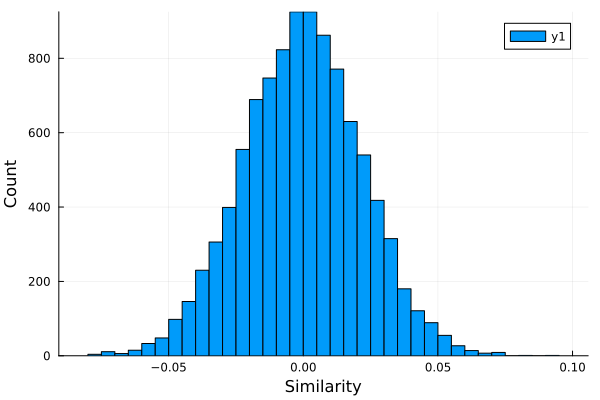

In [17]:
histogram(large_similarity_sample)
xlabel!("Similarity")
ylabel!("Count")

As you can see, the similarity between random vectors turns out to be a Gaussian distribution centered around zero. This is essentially a consequence of the central limit theorem applied to this specific case. So, how long does the vector-symbol need to be for the similarity of random vectors to be approximately zero? We can run a quick experiment to estimate this empirically.

In [18]:
using Statistics: mean, std

function estimate_orthogonality(n_phases::Int, n_samples::Int, rng::AbstractRNG)
    symbol = random_symbols((n_phases, 1), rng)
    codebook = random_symbols((n_phases, n_samples), rng)
    similarity_sample = similarity(symbol, codebook)
    mean_val = mean(similarity_sample)
    std_val = std(similarity_sample)

    return mean_val, std_val
end


estimate_orthogonality (generic function with 1 method)

In [19]:
#generate a logarithmic sweep from 100 to 10,000
dimensions = 10 .^ (1:1/8:4) .|> floor .|> Int;

In [20]:
estimates = estimate_orthogonality.(dimensions, 5000, prng_key) |> stack

2×25 Matrix{Float32}:
 -0.00305187  0.00115434  -0.00263309  …  -1.13221f-5  0.000229704
  0.224095    0.197077     0.172022        0.00821194  0.00708729

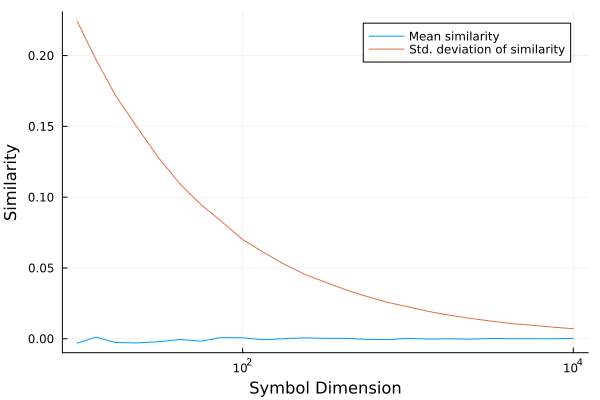

In [21]:
plot(dimensions, estimates[1,:], label="Mean similarity", xaxis=:log)
plot!(dimensions, estimates[2,:], label="Std. deviation of similarity", xaxis=:log)
xlabel!("Symbol Dimension")
ylabel!("Similarity")

As we can see, the distribution of the similarity between random vectors is always centered around zero, but becomes much more sharply peaked at zero as the dimensionality of the vector-symbol increases. In fact, this is an exponential relationship, which we can see by using a log-log chart:

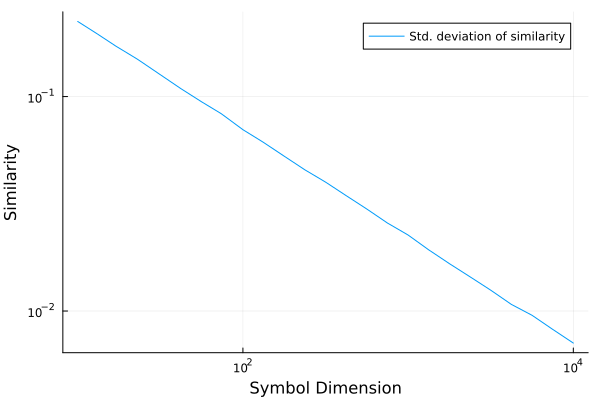

In [22]:
plot(dimensions, estimates[2,:], label="Std. deviation of similarity", xaxis=:log, yaxis=:log)
xlabel!("Symbol Dimension")
ylabel!("Similarity")

So - how is this phenomenon useful? And how does it dovetail to computing with large collections of analog oscillators? To summarize the next few notebooks:

* Symbols that are random *by default* means that operations which specifically manipulate the similarity of two symbols allow us to encode meaningful relationships and data in those values
* By using symbols composed of phase values, phases can be stored in oscillators, and operations for computing and manipulating similarity can be carried out by linking large collections of oscillators!

This yields both a hardware and software paradigm which can be used to explore the applications of materials and devices for analog computing. In the next notebook, we'll demonstrate the same experiment carried out here - but using interference of waves to calculate the same values.

# Exercises

We've seen that we can make vectors of phase values and compare how similar they are using a cosine-based metric; similarity values will therefore be on the range of [-1, 1]. 

Given a symbol *a*, what symbol *b* will produce a similarity of 1.0?

In [ ]:
a = symbol_1; #copy the symbol we used before to "A"
b = ? #what can we set B to which will produce a similarity of 1.0?

In [ ]:
similarity(a, b) # = 1.0?

Following this, how can we modify a symbol to produce a similarity of -1.0 with respect to another vector?

In [ ]:
b = ? #can we modify B to have it produce a similarity of -1 w.r.t. A?
similarity(a, b) # = -1.0

How can we modify B so that it produces a similarity value of - not approximately - but *exactly* 0.0?

In [ ]:
b = ? #can we modify B to have it produce a similarity of *exactly* 0?
similarity(a, b) # = 0.00000000000....

Hint: anything that holds true for two, individual angles where the difference between them has the cosine taken will hold for the entire array. 